In [2]:
import glob
import urllib2
import qctoolkit as qtk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import scipy as sp
plt.style.use('classic')

%matplotlib inline

# Data construction for Alanates

In [3]:
unit = 'ev'

E_Ca = -0.390 # in eV from materials project
E_Sr = -0.419 # in eV from materials project
dE = qtk.convE(E_Ca - E_Sr, 'eV-%s' % unit)[0]
print dE

# raw input sorted by names
ref_raw = qtk.pload('ref.pkl')
pred_raw = qtk.pload('pred.pkl')

0.029


Since E_Sr is lower, every Ca crystals need to be shifted upward by dE

In [4]:
# striping only experimental accessible Ca, Sr alanates
# ditching Mg related alanates

# for reference
ref_raw_all = []
ref_raw_ca = []
ref_raw_sr = []
for r in ref_raw:
    cyl, root = r.name.replace('.out', '').split('-')
    if 'Mg' not in cyl and 'Mg' not in root:
        
        #if 'Mg' not in root:
        if root!='Mg':
            ref_raw_all.append(r)
        if 'Ca' in root:
            ref_raw_ca.append(r)
        if 'Sr' in root:
            ref_raw_sr.append(r)
        #print cyl, root
        
# for prediction
pred_raw_all = []
pred_raw_ca = []
pred_raw_sr = []
for p in pred_raw:
    cyl, root = p.name.replace('out', '').split('-')
    if 'Mg' not in cyl and 'Mg' not in root:
        pred_raw_all.append(p)
        if '2Ca' in root:
            pred_raw_ca.append(p)
        if '2Sr' in root:
            pred_raw_sr.append(p)

In [4]:
print "total number of crystals: ",
print len(ref_raw_all)
print "Ca crystals: ",
print len(ref_raw_ca)
print "Sr crystals: ",
print len(ref_raw_sr)
print "native + swapped = 2*(native)\n"
print "total number of predictions: ",
print len(pred_raw_all)
print "(each reference crystal gets one prediction)"
print "native + swapped Ca crystals predicted by Sr: ",
print len(pred_raw_ca)
print "native + swapped Sr crystals predicted by Ca: ",
print len(pred_raw_sr)

total number of crystals:  172
Ca crystals:  86
Sr crystals:  86
native + swapped = 2*(native)

total number of predictions:  172
(each reference crystal gets one prediction)
native + swapped Ca crystals predicted by Sr:  86
native + swapped Sr crystals predicted by Ca:  86


In [5]:
# construct ordering key

def reorder_ref(outs):
    diffs = []
    for k in range(len(outs)):
        new = copy.deepcopy(outs[k])
        new.inUnit(unit)
        Z = np.array(new.molecule.Z)
        # number of H2 in the form of AlH4
        N = sum(np.ones(new.molecule.N)[Z==13])*(3./4.)
        new.Et = new.Et / N
        diffs.append(new)
    
    news = []
    order_key = np.argsort([r.Et for r in diffs])
    E_base = diffs[order_key[0]].Et
    for k in order_key:
        new = copy.deepcopy(diffs[k])
        new.Et = new.Et - E_base
        news.append(new)
    #for n in news:
    #    n.Et = n.Et - news[0].Et
    return news, order_key

def reorder_pred(outs, order_key):
    diffs = []
    for k in range(len(outs)):
        new = copy.deepcopy(outs[k])
        new.inUnit(unit)
        Z = np.array(new.molecule.Z)
        # number of H2 in the form of AlH4
        N = sum(np.ones(new.molecule.N)[Z==13])*(3./4.)
        new.Et = new.Et / N
        diffs.append(new)
        
    news = []
    E_base = diffs[order_key[0]].Et
    for k in order_key:
        new = copy.deepcopy(diffs[k])
        new.Et = new.Et - E_base
        news.append(new)
    return news
    

ref_sr, key_sr = reorder_ref(ref_raw_sr)
pred_sr = reorder_pred(pred_raw_sr, key_sr)

# shift Ca crystals by a constant difference
ref_ca, key_ca = reorder_ref(ref_raw_ca)
pred_ca = reorder_pred(pred_raw_ca, key_ca)
for i in range(len(ref_ca)):
    o = ref_ca[i]
    o.Et = o.Et + dE
    
    o = pred_ca[i]
    o.Et = o.Et + dE

In [6]:
ref_all_tmp = list(qtk.flatten([ref_sr, ref_ca]))
pred_all_tmp = list(qtk.flatten([pred_sr, pred_ca]))
key = np.argsort([r.Et for r in ref_all_tmp])

ref_all = []
pred_all = []
for k in key:
    ref_all.append(ref_all_tmp[k])
    pred_all.append(pred_all_tmp[k])
    
print len(ref_all)
print len(pred_all)

172
172


In [7]:
# reconstruction of ordered list
ref_ca = []
ref_sr = []
pred_ca = []
pred_sr = []
index_ca = []
index_sr = []
index_all = []
for i in range(len(ref_all)):
    index_all.append(i+1)
    r = copy.deepcopy(ref_all[i])
    p = copy.deepcopy(pred_all[i])
    elem = r.name.replace('.out', '').split('-')[-1]
    
    if elem == 'Sr':
        ref_sr.append(r)
        pred_sr.append(p)
        index_sr.append(i+1)
    elif elem == 'Ca':
        ref_ca.append(r)
        pred_ca.append(p)
        index_ca.append(i+1)

print len(ref_ca), len(ref_sr), len(index_ca), len(index_sr)

86 86 86 86


In [8]:
print index_ca

[4, 6, 7, 10, 13, 14, 16, 17, 18, 21, 22, 23, 27, 29, 30, 32, 35, 36, 37, 44, 45, 47, 48, 49, 51, 53, 54, 56, 57, 59, 64, 68, 71, 72, 74, 75, 77, 78, 79, 80, 83, 84, 86, 88, 89, 94, 97, 98, 100, 103, 104, 105, 108, 110, 111, 114, 115, 119, 120, 123, 124, 125, 126, 127, 128, 129, 134, 136, 137, 139, 140, 141, 146, 147, 149, 150, 152, 155, 157, 160, 161, 163, 165, 168, 169, 171]


In [9]:
# construct plot data
Er_ca = [o.Et for o in ref_ca]
Er_sr = [o.Et for o in ref_sr]
Er_all = [o.Et for o in ref_all]
Ep_ca = [o.Et for o in pred_ca]
Ep_sr = [o.Et for o in pred_sr]
Ep_all = [o.Et for o in pred_all]

# Symmetry name

In [10]:
import os
import glob
import spglib
_subfolder_name = {'i':'isolated', 'p':'polymeric'}

def get_symmetry(index, out_list):
    element, group, name = out_list[index].name.split('_')
    order = name.split('-')[0]
    path = 'alanates/%sAlH4/%s' % (element.title(), _subfolder_name[group])
    mol_string = '%s/poslow%s[_\.]SG[0-9]*.ascii' % (path, order)
    mol_file_list = glob.glob(mol_string)
    if len(mol_file_list) == 1:
        mol = qtk.Molecule(mol_file_list[0])
        cell = (qtk.celldm2lattice(mol.celldm), mol.R_scale, mol.Z)
        #return spg.get_spacegroup(cell, symbol_type=1)
        return spglib.get_spacegroup(cell, symprec=1e-2)
    else:
        return ""
    
def spg_latex(spg):
    grp = spg.split(" ")[0]
    grp = grp.replace('-', r'\bar ')
    return '$' + grp + '$'

spg_list = []
for i in range(len(pred_ca)):
    spg_list.append(get_symmetry(i, pred_ca))
    
    
#     for i in index_ca:
#         print i,
#         element, group, name = pred_ca[i].name.split("_")
#         order= int(name.split('-')[0])
#         print element, group, order

# final plot

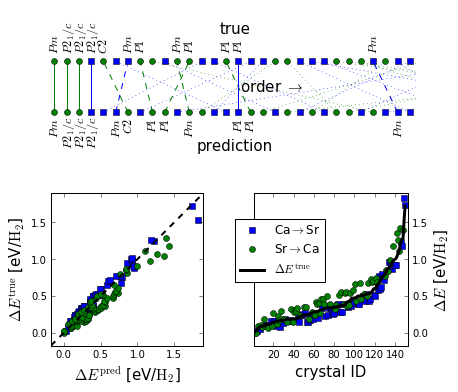

In [11]:
N = 150
Nt = 30
#Nv = len(Er_Ev)
#Nva = len(Evp_ref)

p_max = max(Er_all[:N])
p_min = min(Er_all[:N])
y_min = float(p_min - (p_max - p_min) / 10.)
y_max = float(p_max + (p_max - p_min) / 10.)

fig = plt.figure(figsize=(6.7,6))

gs0 = gridspec.GridSpec(2, 1)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[0])
gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1])

#gs = gridspec.GridSpec(2,2)
ax1 = fig.add_subplot(gs1[0, 0])
ax_scatter = fig.add_subplot(gs2[0, 0])
ax_order = fig.add_subplot(gs2[0, 1])


ax_order.plot(index_ca, Ep_ca, ls='', marker='s', label=r'Ca$\rightarrow$Sr')
ax_order.plot(index_sr, Ep_sr, ls='', marker='o', label=r'Sr$\rightarrow$Ca')
ax_order.plot(index_all[:N], Er_all[:N], ls='-', color='k', lw=3, label=r'$\Delta E^{\mathrm{true}}$')
#ax_order.plot(1000, 1000, color='r', marker='^', label=r'$E_v^{\mathrm{AlGaAs}}$', ls='')
#ax_order.plot(1000, 1000, color='m', marker='v', label=r'$E_v^{\mathrm{AlGaP}}$', ls='')
ax_order.set_xlabel('crystal ID', fontsize=15)
ax_order.set_ylabel('$\Delta E$ [eV/$\mathrm{H}_2$]', fontsize=15)
ax_order.yaxis.tick_right()
ax_order.yaxis.set_label_position("right")
# ax_order.xaxis.tick_top()
# ax_order.xaxis.set_label_position("top")
ax_order.set_xlim([1, N+3])
ax_order.set_ylim([y_min, y_max])
ax_order.legend(loc=(-0.12, 0.42), numpoints=1)
ax_order.set_zorder(100)
ax_order.set_aspect(float(N)/(y_max - y_min))

ax_scatter.plot(Ep_ca[:N], Er_ca[:N], ls='', marker='s')
ax_scatter.plot(Ep_sr[:N], Er_sr[:N], ls='', marker='o')
ax_scatter.plot([y_min, y_max], [y_min, y_max], color='k', ls='--', lw=2)
ax_scatter.set_aspect('equal')
ax_scatter.set_xlim(y_min, y_max)
ax_scatter.set_ylim(y_min, y_max)
# ax_scatter.xaxis.tick_top()
# ax_scatter.xaxis.set_label_position("top")
ax_scatter.set_ylabel('$\Delta E^{\mathrm{true}}$ [eV/$\mathrm{H}_2$]', fontsize=15)
ax_scatter.set_xlabel('$\Delta E^{\mathrm{pred}}$ [eV/$\mathrm{H}_2$]', fontsize=15)


order_true = index_all
order_pred = (np.argsort(Ep_all)+1).tolist()
conn_x_list = zip(order_pred, order_true)
conn_y_list = zip([1 for _ in index_all], [2 for _ in index_all])
for i in range(len(conn_x_list)):
    spg_ref = get_symmetry(i, ref_all)
    spg_pred = get_symmetry(i, pred_all)
    cx = conn_x_list[i]
    cy = conn_y_list[i]
    if cx[0] < Nt and cx[1] < Nt:
        if abs(cx[0] - cx[1]) == 0:
            if cx[1] in index_ca:
                ax1.plot(cx, cy, color='b', marker='s')
            elif cx[1] in index_sr:
                ax1.plot(cx, cy, color='g', marker='o')
            x, y = cx[0], cy[0]
            ax1.annotate(
                spg_latex(spg_pred), 
                xy=(x - 0.5, y - 0.3), 
                xytext=(x - 0.5, y - 0.3),
                rotation = 90,
                fontsize=12,
            )
            x, y = cx[1], cy[1]
            ax1.annotate(
                spg_latex(spg_ref), 
                xy=(x - 0.5, y + 0.15), 
                xytext=(x - 0.5, y + 0.15),
                rotation = 90,
                fontsize=12,
                va='bottom',
            )
        elif abs(cx[0] - cx[1]) <= 3:
            if cx[1] in index_ca:
                ax1.plot(cx, cy, color='b', marker='s', ls='--')
            elif cx[1] in index_sr:
                ax1.plot(cx, cy, color='g', marker='o', ls='--')
            x, y = cx[0], cy[0]
            ax1.annotate(
                spg_latex(spg_pred),
                xy=(x - 0.5, y - 0.3), 
                xytext=(x - 0.5, y - 0.3),
                rotation = 90,
                fontsize=12,
            )
            x, y = cx[1], cy[1]
            ax1.annotate(
                spg_latex(spg_ref),
                xy=(x - 0.5, y + 0.15), 
                xytext=(x - 0.5, y + 0.15),
                rotation = 90,
                fontsize=12,
                va='bottom',
            )
        else:
            if cx[1] in index_ca:
                ax1.plot(cx, cy, color='b', marker='s', ls=':',lw=0.5)
            elif cx[1] in index_sr:
                ax1.plot(cx, cy, color='g', marker='o', ls=':',lw=0.5)
    else:
        if cx[1] in index_ca:
            ax1.plot(cx, cy, color='b', marker='s', ls=':',lw=0.5)
        elif cx[1] in index_sr:
            ax1.plot(cx, cy, color='g', marker='o', ls=':',lw=0.5)
ax1.text((Nt+1.5)/2., 0.25, "prediction", fontsize=15, ha='center')
ax1.text((Nt+1.5)/2. + 3, 1.4, r"order $\rightarrow$", fontsize=15, ha='center')
ax1.text((Nt+1.5)/2., 2.55, "true", fontsize=15, ha='center')
ax1.set_ylim(0,3)
ax1.set_xlim(0,Nt+0.5)
ax1.axis('off')


# # histogram inset
# order_diff = np.abs(np.array(order_pred) - np.array(order_true))
# ax_i = plt.axes([.565, .54, .32, .38])
# ax_i.hist(order_diff, bins=10, color='0.7')
# ax_i.set_xlabel(r'|$\Delta$rank|', fontsize=15)
# ax_i.set_ylabel('counts', fontsize=15)
# ax_i.yaxis.tick_right()
# ax_i.yaxis.set_label_position("right")
# ax_i.xaxis.tick_top()
# ax_i.xaxis.set_label_position("top")



#plt.tight_layout(w_pad=-1)
plt.savefig('order_plot.pdf')

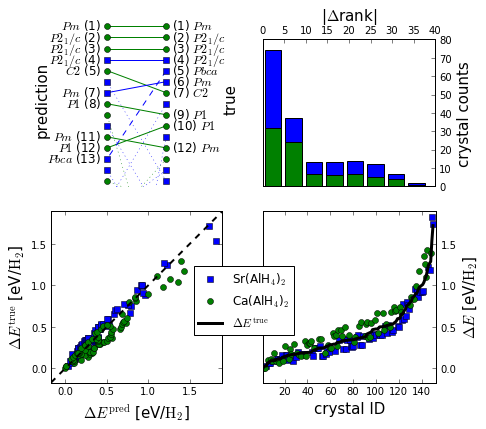

In [91]:
N = 150
Nt = 15
#Nv = len(Er_Ev)
#Nva = len(Evp_ref)

p_max = max(Er_all[:N])
p_min = min(Er_all[:N])
y_min = float(p_min - (p_max - p_min) / 10.)
y_max = float(p_max + (p_max - p_min) / 10.)

fig = plt.figure(figsize=(6.7,6))

gs0 = gridspec.GridSpec(2, 1)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[0])
gs2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs0[1])

#gs = gridspec.GridSpec(2,2)
ax1 = fig.add_subplot(gs1[0, 0])
ax_noshow = fig.add_subplot(gs1[0, 1])
ax_scatter = fig.add_subplot(gs2[0, 0])
ax_order = fig.add_subplot(gs2[0, 1])

ax_noshow.axis('off')


ax_order.plot(index_ca, Ep_ca, ls='', marker='s', label=r'Sr(AlH$_4$)$_2$')
ax_order.plot(index_sr, Ep_sr, ls='', marker='o', label=r'Ca(AlH$_4$)$_2$')
ax_order.plot(index_all[:N], Er_all[:N], ls='-', color='k', lw=3, label=r'$\Delta E^{\mathrm{true}}$')
#ax_order.plot(1000, 1000, color='r', marker='^', label=r'$E_v^{\mathrm{AlGaAs}}$', ls='')
#ax_order.plot(1000, 1000, color='m', marker='v', label=r'$E_v^{\mathrm{AlGaP}}$', ls='')
ax_order.set_xlabel('crystal ID', fontsize=15)
ax_order.set_ylabel('$\Delta E$ [eV/$\mathrm{H}_2$]', fontsize=15)
ax_order.yaxis.tick_right()
ax_order.yaxis.set_label_position("right")
# ax_order.xaxis.tick_top()
# ax_order.xaxis.set_label_position("top")
ax_order.set_xlim([1, N+3])
ax_order.set_ylim([y_min, y_max])
ax_order.set_zorder(100)
ax_order.set_aspect(float(N)/(y_max - y_min))

ax_scatter.plot(Ep_ca[:N], Er_ca[:N], ls='', marker='s')
ax_scatter.plot(Ep_sr[:N], Er_sr[:N], ls='', marker='o')
ax_scatter.plot([y_min, y_max], [y_min, y_max], color='k', ls='--', lw=2)
ax_scatter.set_aspect('equal')
ax_scatter.set_xlim(y_min, y_max)
ax_scatter.set_ylim(y_min, y_max)
# ax_scatter.xaxis.tick_top()
# ax_scatter.xaxis.set_label_position("top")
ax_scatter.set_ylabel('$\Delta E^{\mathrm{true}}$ [eV/$\mathrm{H}_2$]', fontsize=15)
ax_scatter.set_xlabel('$\Delta E^{\mathrm{pred}}$ [eV/$\mathrm{H}_2$]', fontsize=15)


order_true = index_all
order_pred = (np.argsort(Ep_all)+1).tolist()
conn_x_list = zip(order_pred, order_true)
conn_y_list = zip([2 for _ in index_all], [1 for _ in index_all])
for i in range(len(conn_x_list)):
    spg_ref = get_symmetry(i, ref_all)
    spg_pred = get_symmetry(i, pred_all)
    cx = conn_x_list[i]
    cy = conn_y_list[i]
    if cx[0] < Nt and cx[1] < Nt:
        if abs(cx[0] - cx[1]) <= 5:
            if cx[1] in index_ca:
                ax1.plot(cy, cx, color='b', marker='s')
            elif cx[1] in index_sr:
                ax1.plot(cy, cx, color='g', marker='o')
            x, y = cx[0], cy[0]
            ax1.annotate(
                '(%d) ' % conn_x_list[i][0] + spg_latex(spg_pred), 
                xy=(y + 0.1, x+0.3), 
                xytext=( y + 0.1, x+0.3),
                #rotation = 90,
                fontsize=12,
            )
            x, y = cx[1], cy[1]
            ax1.annotate(
                spg_latex(spg_ref) + ' (%d)' % conn_x_list[i][1], 
                xy=(y - 0.1, x+0.3), 
                xytext=(y - 0.1, x+0.3),
                #rotation = 90,
                fontsize=12,
                ha='right',
            )
        elif abs(cx[0] - cx[1]) <= 10:
            if cx[1] in index_ca:
                ax1.plot(cy, cx, color='b', marker='s', ls='--')
            elif cx[1] in index_sr:
                ax1.plot(cy, cx, color='g', marker='o', ls='--')
            x, y = cx[0], cy[0]
            ax1.annotate(
                '(%d) ' % conn_x_list[i][0] + spg_latex(spg_pred),
                xy=(y + 0.1, x+0.3), 
                xytext=(y + 0.1, x+0.3),
                #rotation = 90,
                fontsize=12,
            )
            x, y = cx[1], cy[1]
            ax1.annotate(
                spg_latex(spg_ref) + ' (%d)' % conn_x_list[i][1],
                xy=(y - 0.1, x+0.3), 
                xytext=(y - 0.1, x+0.3),
                #rotation = 90,
                fontsize=12,
                ha='right',
            )
        else:
            if cx[1] in index_ca:
                ax1.plot(cy, cx, color='b', marker='s', ls=':',lw=0.5)
            elif cx[1] in index_sr:
                ax1.plot(cy, cx, color='g', marker='o', ls=':',lw=0.5)
    else:
        if cx[1] in index_ca:
            ax1.plot(cy, cx, color='b', marker='s', ls=':',lw=0.5)
        elif cx[1] in index_sr:
            ax1.plot(cy, cx, color='g', marker='o', ls=':',lw=0.5)
ax1.text(-0.1, (Nt+1.5)/2.-3, "prediction", rotation = 90, fontsize=15, ha='center')
#ax1.text(1.4, (Nt+1.5)/4. + 3, r"order $\rightarrow$", rotation = -90, fontsize=15, ha='center')
ax1.text(3.1, (Nt+1.5)/2.-1, "true", rotation = 90, fontsize=15, ha='center')
ax1.set_xlim(0,3)
ax1.set_ylim(Nt+0.5,0)
ax1.axis('off')
ax1.fill_betweenx([0,3], 15.5, 32, color='w', zorder=100)


# histogram inset
order_diff = np.abs(np.array(order_pred) - np.array(order_true))
ax_i = plt.axes([.54, .57, .358, .34])
hist_data = np.stack([order_diff[np.array(index_ca)-1], order_diff[np.array(index_sr) - 1]]).T
ax_i.hist(hist_data, bins=8, color=['g', 'b'], stacked=True)
ax_i.set_xlabel(r'|$\Delta$rank|', fontsize=15)
ax_i.set_ylabel('crystal counts', fontsize=15)
ax_i.yaxis.tick_right()
ax_i.yaxis.set_label_position("right")
ax_i.xaxis.tick_top()
ax_i.xaxis.set_label_position("top")

ax_order.legend(loc=(-0.4, 0.28), numpoints=1)


plt.tight_layout(w_pad=-1)
plt.savefig('order_plot.pdf')

In [87]:
np.stack([order_diff[np.array(index_ca)-1], order_diff[np.array(index_sr) - 1]]).T.shape

(86, 2)

# Analysis

In [103]:
E_fit = qtk.ML.l2_fit(Ep_all, Er_all)
print qtk.ML.error_measure(Er_all, E_fit)

(0.96141873753108609, 0.11806596251988263, 0.083227114301860194)


In [ ]:
print qtk.ML.error_measure

In [99]:
len(order_diff[order_diff < 10]) / float(len(order_diff))


0.6453488372093024

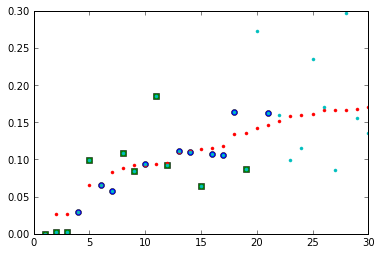

In [13]:
Ns = 10
plt.plot(index_ca[:Ns], Ep_ca[:Ns], ls='', marker='o')
plt.plot(index_sr[:Ns], Ep_sr[:Ns], ls='', marker='s')
plt.plot(index_all[:2*Ns+10], Er_all[:2*Ns+10], ls='', marker='.')
plt.plot(index_all[:2*Ns+10], Ep_all[:2*Ns+10], ls='', marker='.')



9.63953488372 9.45357418652


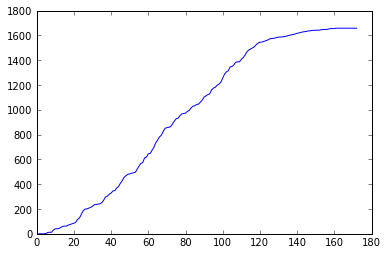

In [14]:
order_diff = np.abs(np.array(order_pred) - np.array(order_true))
plt.plot(order_true, order_diff.cumsum())
print order_diff.mean(), order_diff.std()

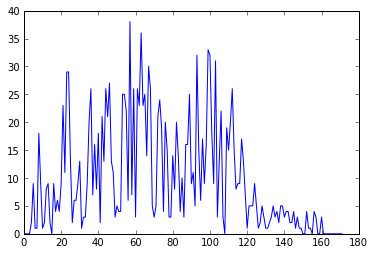

In [15]:
plt.plot(order_diff)

(array([ 62.,  32.,  21.,  13.,   9.,  11.,  14.,   4.,   4.,   2.]),
 array([  0. ,   3.8,   7.6,  11.4,  15.2,  19. ,  22.8,  26.6,  30.4,
         34.2,  38. ]),
 <a list of 10 Patch objects>)

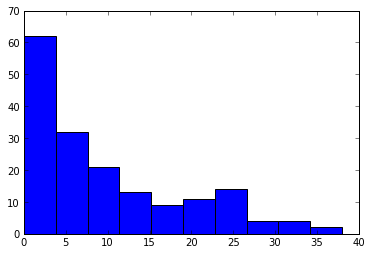

In [16]:
plt.hist(order_diff, bins=10)

In [49]:
def normal(*args):
    return np.random.normal(loc=order_diff.mean(), scale=order_diff.std())

In [68]:
np.random.normal
sp.stats.kstest(order_diff, normal)

KstestResult(statistic=7.237498423589785, pvalue=nan)

In [14]:
type(ref_raw[0])

qctoolkit.QM.qmcode.abinit.out

(0, 20)

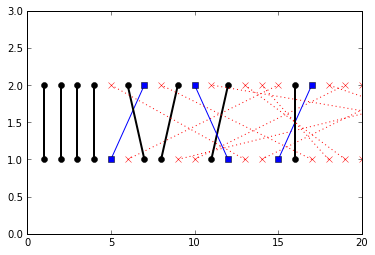

In [15]:
Nt = 170
order_true = index_all[:Nt]
order_pred = (np.argsort(Ep_all)[:Nt]+1).tolist()
conn_x_list = zip(order_true, order_pred)
conn_y_list = zip([1 for _ in range(Nt)], [2 for _ in range(Nt)])
for i in range(Nt):
    cx = conn_x_list[i]
    cy = conn_y_list[i]
    if abs(cx[0] - cx[1]) <= 1:
        plt.plot(cx, cy, color='k', marker='o', lw=2)
    elif abs(cx[0] - cx[1]) <= 3:
        plt.plot(cx, cy, color='b', marker='s')
    else:
        plt.plot(cx, cy, color='r', marker='x', ls=':')
plt.ylim(0,3)
plt.xlim(0,20)

In [16]:
print order_true[:10]
print order_pred[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1, 2, 3, 4, 7, 15, 6, 9, 27, 19]


In [17]:
ref_ca[3].name

'Ca_p_04-Ca.out'

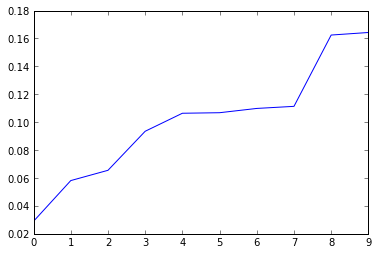

In [18]:
plt.plot(sorted([o.Et for o in pred_ca[:10]]))

# Correlation score

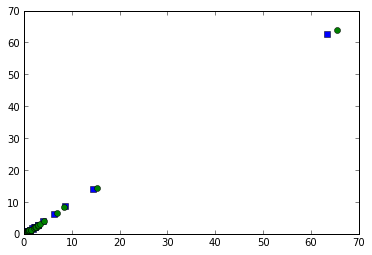

In [13]:
plt.plot(Ep_ca[:N], Er_ca[:N], ls='', marker='s')
plt.plot(Ep_sr[:N], Er_sr[:N], ls='', marker='o')

(0.99985564028778662, 8.3933351729878687e-303)

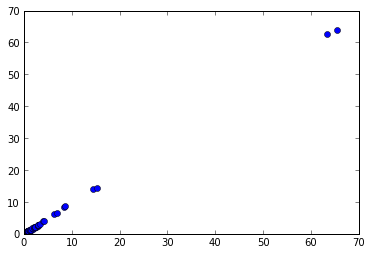

In [35]:
N = 200
x, y = Ep_all[:N], Er_all[:N]
plt.plot(x, y, ls='', marker='o')

sp.stats.pearsonr(x, y)

In [49]:
print sp.stats.pointbiserialr(x, y)

print sp.stats.ks_2samp(x, y)

print sp.stats.kendalltau(x, y)

print sp.stats.weightedtau(x,y)

print sp.stats.ranksums(x, y)

print sp.stats.ansari(x, y)

print sp.stats.mood(x, y)

print sp.stats.binned_statistic(x, y)

PointbiserialrResult(correlation=0.99985564028778662, pvalue=8.3933351729878687e-303)
Ks_2sampResult(statistic=0.058139534883720978, pvalue=0.92596458721149089)
KendalltauResult(correlation=0.85209998348882954, pvalue=8.2357842221166648e-62)
WeightedTauResult(correlation=0.94841200044178264, pvalue=nan)
RanksumsResult(statistic=0.16373049540033416, pvalue=0.86994330964235966)
AnsariResult(statistic=14784.0, pvalue=0.83846836401848512)
(0.45938982732920575, 0.64595425203866597)
BinnedStatisticResult(statistic=array([  0.64851084,   7.86016863,  14.22990279,          nan,
                nan,          nan,          nan,          nan,
                nan,  63.24625994]), bin_edges=array([  0.        ,   6.54898764,  13.09797529,  19.64696293,
        26.19595057,  32.74493822,  39.29392586,  45.8429135 ,
        52.39190115,  58.94088879,  65.48987643]), binnumber=array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 

BinnedStatisticResult(statistic=array([  0.64851084,   7.86016863,  14.22990279,          nan,
                nan,          nan,          nan,          nan,
                nan,  63.24625994]), bin_edges=array([  0.        ,   6.54898764,  13.09797529,  19.64696293,
        26.19595057,  32.74493822,  39.29392586,  45.8429135 ,
        52.39190115,  58.94088879,  65.48987643]), binnumber=array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        